## Re-id各种Trick测试

In [1]:
import torch
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import torchvision
import torch.optim as opt
import numpy as np
from PIL import Image
import math
import random

In [2]:
# 参数设置
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
# 加载图像
image = Image.open(r'G:/datasets/Market-1501/pytorch/train/0114/0114_c2s3_071702_01.jpg')
print(image.height,image.width)

128 64


In [3]:
# 展示函数
def show(img,transform=None):
    if transforms is not None:
        for i in range(4):
            plt.subplot(221 + i)
            plt.axis('off')
            t= transform(img)
            if isinstance(t, torch.Tensor):
                t = t.numpy()
                t = np.transpose(t,(1,2,0))
            plt.imshow(t)
        print(str(transform))
        print(t)
    else:
        plt.imshow(img)
        plt.axis('off')

    plt.show()

### 水平翻转

RandomHorizontalFlip(p=0.5)
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x128 at 0x1BEAE37AD30>


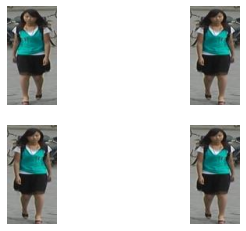

In [4]:
transform_rf = transforms.RandomHorizontalFlip(p=0.5) # 水平翻转
show(image,transform_rf)

### 改变大小

Resize(size=(256, 128), interpolation=PIL.Image.BILINEAR)
<PIL.Image.Image image mode=RGB size=128x256 at 0x1BEAE63BAF0>


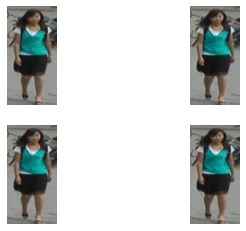

In [5]:
transform_resize = transforms.Resize((256,128))
show(image,transform_resize)

### 填充像素

Pad(padding=10, fill=0, padding_mode=constant)
<PIL.Image.Image image mode=RGB size=84x148 at 0x1BEAE743FA0>


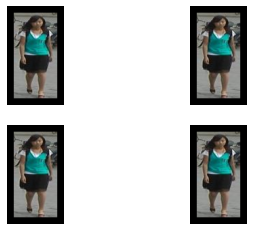

Pad(padding=10, fill=0, padding_mode=edge)
<PIL.Image.Image image mode=RGB size=84x148 at 0x1BEAE57CC70>


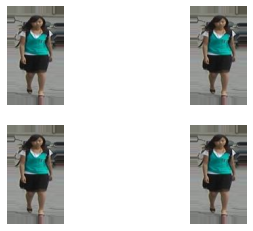

Pad(padding=10, fill=0, padding_mode=reflect)
<PIL.Image.Image image mode=RGB size=84x148 at 0x1BEAE5DA5E0>


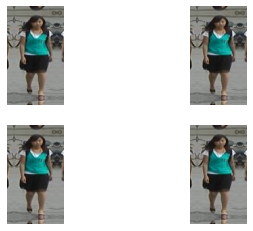

In [6]:
show(image,transforms.Pad(10))
show(image,transforms.Pad(10,padding_mode='edge'))
show(image,transforms.Pad(10,padding_mode='reflect'))

### 颜色抖动

ColorJitter(brightness=[0.9, 1.1], contrast=None, saturation=None, hue=None)
<PIL.Image.Image image mode=RGB size=64x128 at 0x1BEAE860A60>


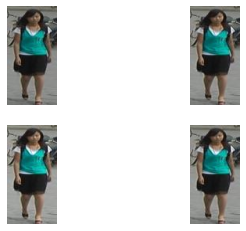

ColorJitter(brightness=None, contrast=[0.9, 1.1], saturation=None, hue=None)
<PIL.Image.Image image mode=RGB size=64x128 at 0x1BEAE95D040>


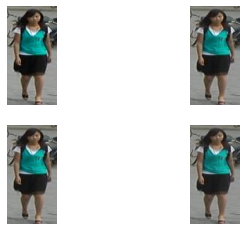

ColorJitter(brightness=None, contrast=None, saturation=[0.9, 1.1], hue=None)
<PIL.Image.Image image mode=RGB size=64x128 at 0x1BEAEA69610>


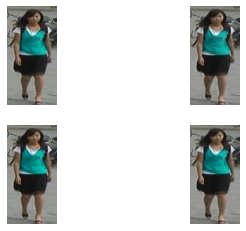

ColorJitter(brightness=None, contrast=None, saturation=None, hue=[-0.1, 0.1])
<PIL.Image.Image image mode=RGB size=64x128 at 0x1BEAE77D5B0>


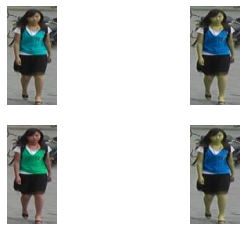

In [7]:
show(image, transforms.ColorJitter(brightness=0.1))  # 亮度
show(image, transforms.ColorJitter(contrast=0.1))  # 对比度
show(image, transforms.ColorJitter(saturation=0.1))  # 饱和度
show(image, transforms.ColorJitter(hue=0.1))  # 色调，只能是-0.5~0.5，应该指的是可以逆时针旋转180度或顺时针旋转180度

### warm-up策略

In [8]:
lr_start = 0.00035
model = torchvision.models.resnet50(pretrained=True)  # 预训练
optimizer = opt.SGD(model.parameters(),lr=lr_start)

In [9]:
# 设计分段函数
def lambda_lr(epoch):
    curr_lr = 1
    if epoch <= 10:
        curr_lr = epoch / 10 
    elif 10 < epoch <= 40:
        curr_lr = 1
    elif 40 < epoch <= 70:
        curr_lr = 0.1
    elif 70 < epoch <= 120:
        curr_lr = 0.01
    else:
        curr_lr = 0.1
    return curr_lr 

scheduler = opt.lr_scheduler.LambdaLR(optimizer,lr_lambda=lambda_lr)

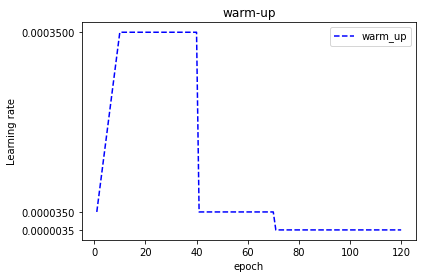

In [10]:
x_epoch = []
lr_list = []

optimizer.zero_grad()
optimizer.step()

for epoch in range(1,121):
    
    x_epoch.append(epoch)
    scheduler.step(epoch)
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

plt.title('warm-up')
plt.xlabel('epoch')
plt.ylabel('Learning rate')
plt.yticks([3.5e-6,3.5e-5,3.5e-4])
plt.plot(x_epoch,lr_list,'b--',label='warm_up')
plt.legend()
plt.show()


### 随机裁剪


RandomCrop(size=(128, 64), padding=None)
<PIL.Image.Image image mode=RGB size=64x128 at 0x1BEAE9AAB80>


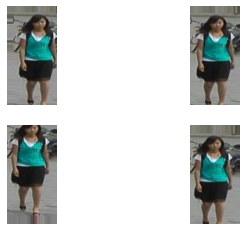

In [11]:
t_tmp= transforms.Pad(10,padding_mode='edge')
image_tmp = t_tmp(image)
transform_rrc = transforms.RandomCrop(size=(128,64))
show(image_tmp,transform_rrc)

### 随机擦除策略

In [12]:
class RandomErasing(object):
    def __init__(self,p=0.5, sl=0.02, sh=0.4, r=0.3, mean=[0, 0, 0]):
        self.p = p
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r = r

    def __call__(self,img):
        if random.uniform(0,1) > self.p:
            return Image.fromarray(img)

        height, width = img.shape[0], img.shape[1]
        for attempt in range(10):
            area = height * width
            target_area = random.uniform(self.sl , self.sh) * area # 目标面积
            aspect_ratio = random.uniform(self.r, 1 / self.r)  # 随机生成长宽比
            w = int(round(math.sqrt(target_area * aspect_ratio)))  
            h =  int(round(math.sqrt(target_area / aspect_ratio)))  

            if w < width and h < height:
                x_e = random.randint(0, width - w)
                y_e = random.randint(0, height - h)

                img[x_e:x_e + w, y_e:y_e + h, 0] = self.mean[0]
                img[x_e:x_e + w, y_e:y_e + h, 1] = self.mean[1]
                img[x_e:x_e + w, y_e:y_e + h, 2] = self.mean[2]

                return Image.fromarray(img)

        return Image.fromarray(img)

(128, 64, 3)
<PIL.Image.Image image mode=RGB size=64x128 at 0x1BEAE9F9490>


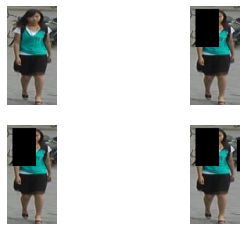

In [13]:
transform_re = RandomErasing(p = 0.5)
image_np = np.array(image)
print(image_np.shape)
show(image_np, transform_re)

RandomErasing()
[[[0.47843137 0.4862745  0.44313726]
  [0.47058824 0.47843137 0.43529412]
  [0.4745098  0.48235294 0.4392157 ]
  ...
  [0.3019608  0.29411766 0.24705882]
  [0.30588236 0.29803923 0.2509804 ]
  [0.34117648 0.33333334 0.28627452]]

 [[0.52156866 0.5294118  0.4862745 ]
  [0.5176471  0.5254902  0.48235294]
  [0.5137255  0.52156866 0.47843137]
  ...
  [0.3137255  0.30588236 0.25882354]
  [0.33333334 0.3254902  0.2784314 ]
  [0.3529412  0.34509805 0.29803923]]

 [[0.53333336 0.5411765  0.49803922]
  [0.5372549  0.54509807 0.5019608 ]
  [0.54509807 0.5529412  0.50980395]
  ...
  [0.3529412  0.3529412  0.30588236]
  [0.38039216 0.38039216 0.33333334]
  [0.38039216 0.38039216 0.33333334]]

 ...

 [[0.49411765 0.5019608  0.49019608]
  [0.49803922 0.5058824  0.49411765]
  [0.5058824  0.5137255  0.5019608 ]
  ...
  [0.52156866 0.5294118  0.5176471 ]
  [0.5411765  0.54901963 0.5372549 ]
  [0.5529412  0.56078434 0.54901963]]

 [[0.4627451  0.47058824 0.45882353]
  [0.47058824 0.47843

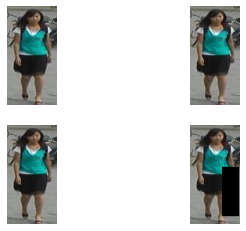

In [14]:
# 用api试试
transform_tensor = transforms.ToTensor()
img_tensor = transform_tensor(image)
show(img_tensor, transform=transforms.RandomErasing(p=0.5))